### Setup

In [76]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import urllib2
import scipy.stats as stats

np.set_printoptions(precision=3, suppress=True)
url = ('https://raw.githubusercontent.com/Upward-Spiral-Science'
       '/data/master/syn-density/output.csv')
data = urllib2.urlopen(url)
csv = np.genfromtxt(data, delimiter=",")[1:] # don't want first row (labels)

# chopping data based on thresholds on x and y coordinates
x_bounds = (409, 3529)
y_bounds = (1564, 3124)

def check_in_bounds(row, x_bounds, y_bounds):
    if row[0] < x_bounds[0] or row[0] > x_bounds[1]:
        return False
    if row[1] < y_bounds[0] or row[1] > y_bounds[1]:
        return False
    if row[3] == 0:
        return False
    
    return True

indices_in_bound, = np.where(np.apply_along_axis(check_in_bounds, 1, csv,
                                                 x_bounds, y_bounds))
data_thresholded = csv[indices_in_bound]
n = data_thresholded.shape[0]


def synapses_over_unmasked(row):
    s = (row[4]/row[3])*(64**3)
    return [row[0], row[1], row[2], s]

syn_unmasked = np.apply_along_axis(synapses_over_unmasked, 1, data_thresholded)
syn_normalized = syn_unmasked

### Boxplot of synaptic densitsy

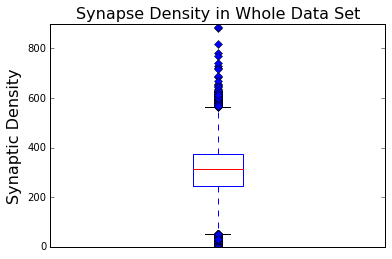

In [27]:
plt.boxplot(syn_unmasked[:,3], 0, 'gD')
plt.xticks([1], [''])
plt.yticks([0,200,400,600,800])
plt.ylabel('Synaptic Density', fontsize=16)
plt.title('Synapse Density in Whole Data Set', fontsize=16)
plt.show()

### Boxplot of different clusters by coordinates and densities

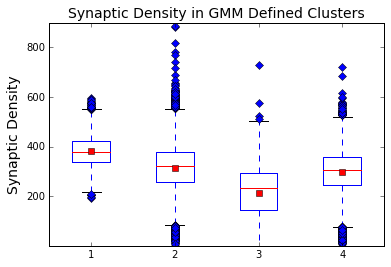

In [25]:
import sklearn.mixture as mixture

n_clusters = 4
gmm = mixture.GMM(n_components=n_clusters, n_iter=1000, covariance_type='diag')
labels = gmm.fit_predict(syn_unmasked)
clusters = []
for l in range(n_clusters):
    a = np.where(labels == l)
    clusters.append(syn_unmasked[a,:])

counter = 0
indx = 0
indy = 0
data = []
for cluster in clusters:
    s = cluster.shape
    cluster = cluster.reshape((s[1], s[2]))
    counter += 1
    data.append(cluster[:,-1])
plt.boxplot(data, 0, 'gD', showmeans=True)
plt.xticks([1,2,3,4])
plt.yticks([0, 200, 400, 600, 800])
plt.ylabel('Synaptic Density', fontsize=14)
plt.title('Synaptic Density in GMM Defined Clusters', fontsize=14)
plt.show()

### Z-layer density distributions visualized as boxplots

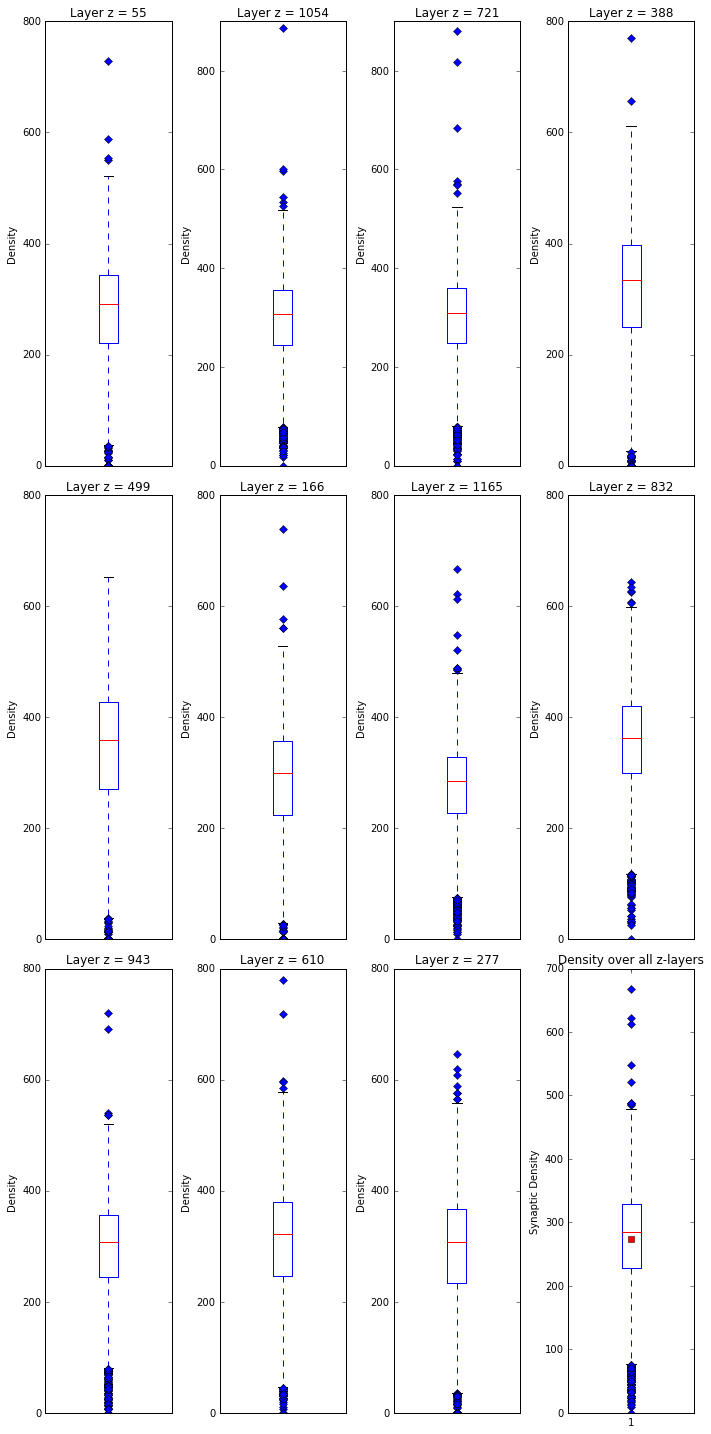

In [32]:
data_uniques, UIndex, UCounts = np.unique(syn_unmasked[:,2], return_index = True, return_counts = True)
'''
print 'uniques'
print 'index: ' + str(UIndex)
print 'counts: ' + str(UCounts)
print 'values: ' + str(data_uniques)
'''
fig, ax = plt.subplots(3,4,figsize=(10,20))
counter = 0

for i in np.unique(syn_unmasked[:,2]):
    # print 'calcuating for z: ' + str(int(i))
    
    def check_z(row):
        if row[2] == i:
            return True
        return False
   
    counter += 1
    xind = (counter%3) - 1
    yind = (counter%4) - 1
     
    index_true = np.where(np.apply_along_axis(check_z, 1, syn_unmasked))
    syn_uniqueZ = syn_unmasked[index_true]
    
    ax[xind,yind].boxplot(syn_uniqueZ[:,3], 0, 'gD')
    ax[xind,yind].set_xticks([''])
    ax[xind,yind].set_yticks([0,200,400,600,800])
    ax[xind,yind].set_ylabel('Density')
    ax[xind,yind].set_title('Layer z = ' + str(int(i)))

ax[xind+1,yind+1].boxplot(syn_uniqueZ[:,3], 0, 'gD',showmeans=True)
ax[xind+1,yind+1].set_xticks([1], 'set')
ax[xind+1,yind+1].set_ylabel('Synaptic Density')
ax[xind+1,yind+1].set_title('Density over all z-layers')

plt.tight_layout()

plt.show()
    

### Spike

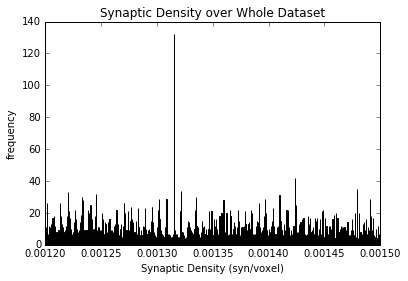

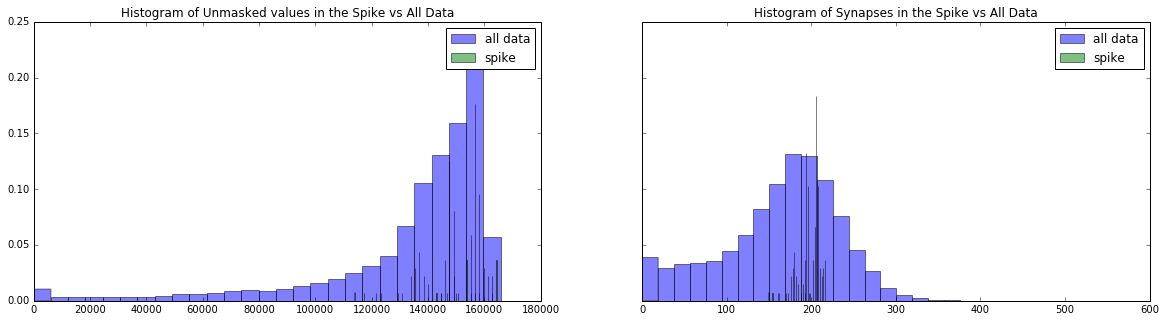

In [77]:
# Spike
a = np.apply_along_axis(lambda x:x[4]/x[3], 1, data_thresholded)
spike = a[np.logical_and(a <= 0.0015, a >= 0.0012)]

# Histogram
n, bins, _ = plt.hist(spike, 2000)
plt.title('Synaptic Density over Whole Dataset')
plt.xlabel('Synaptic Density (syn/voxel)')
plt.ylabel('frequency')

bin_max = np.where(n == n.max())
bin_width = bins[1]-bins[0]
syn_normalized[:,3] = syn_normalized[:,3]/(64**3)
spike = syn_normalized[np.logical_and(syn_normalized[:,3] <= 0.00131489435301+bin_width, syn_normalized[:,3] >= 0.00131489435301-bin_width)]
spike_thres = data_thresholded[np.logical_and(syn_normalized[:,3] <= 0.00131489435301+bin_width, syn_normalized[:,3] >= 0.00131489435301-bin_width)]
import math
fig, ax = plt.subplots(1,2,sharey = True, figsize=(20,5))
weights = np.ones_like(spike_thres[:,3])/len(spike_thres[:,3])
weights2 = np.ones_like(data_thresholded[:,3])/len(data_thresholded[:,3])

data_bins = int(len(spike_thres[:,3])/5)
spike_bins = int(len(data_thresholded[:,3])/10)


ax[0].hist(data_thresholded[:,3], bins = data_bins, alpha = 0.5, weights = weights2, label = 'all data')
ax[0].hist(spike_thres[:,3], bins = spike_bins, alpha = 0.5, weights = weights, label = 'spike')
ax[0].legend(loc='upper right')
ax[0].set_title('Histogram of Unmasked values in the Spike vs All Data')

weights = np.ones_like(spike_thres[:,4])/len(spike_thres[:,4])
weights2 = np.ones_like(data_thresholded[:,4])/len(data_thresholded[:,4])

ax[1].hist(data_thresholded[:,4], bins = data_bins, alpha = 0.5, weights = weights2, label = 'all data')
ax[1].hist(spike_thres[:,4], bins = spike_bins, alpha = 0.5, weights = weights, label = 'spike')
ax[1].legend(loc='upper right')
ax[1].set_title('Histogram of Synapses in the Spike vs All Data')

plt.show()